## Dependencies

In [4]:
from numpy.random import choice
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from collections import Counter
from scipy.optimize import fsolve
#from multisensory_playbook import DetectionTask_Etrans_test

import warnings
warnings.simplefilter(action='ignore', category=Warning)

## Functions

In [2]:
# Plot time series and loglog plots
def timeseriesplot(x, rlim, y, label, log):
    if log:
        plt.loglog(x[:rlim], y, marker='|', ms = 5, linewidth = 1, label=label)
        plt.title('Log–log plot')
        
    else:
        plt.plot(x[:rlim], y, marker='|', ms = 5, linewidth = 1, label=label)
        ax = plt.gca()  # Get the current axis
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-1,1))  # This will force scientific notation for all numbers
        ax.xaxis.set_major_formatter(formatter)
        
    plt.ylabel('Time (s)')
    plt.xlabel('Steps')
    plt.legend(frameon=False)
    plt.legend(frameon=False)

In [3]:
# Explore shapes of datastructures
def print_structure(obj, level=0):
    indent = "  " * level
    if isinstance(obj, tuple):
        print(f"{indent}Tuple: Length {len(obj)}")
        for item in obj:
            print_structure(item, level + 1)
    elif isinstance(obj, list):
        print(f"{indent}List: Length {len(obj)}")
        for item in obj:
            print_structure(item, level + 1)
    else:
        print(f"{indent}Type: {type(obj)}")
#print_tuple_structure(test)


In [4]:
# Detection task trial (minimal modifications from paper)
detection_execution_times = []
def detection_trial(n, pm, pe, pn, pc, pi,run, do_return=True, seed=None):
    start_time = time.time()  # Start the timer
    if seed is not None:
        np.random.seed(seed)  # Set the seed for reproducibility
    
    M = choice([-1, 0, 1], p=[pm/2, 1 -pm, pm/2])
    if run == 0:
        M = 1
    E = []; A = []; V = [];
    for t in range(n):
        # emit variable depends on M
        if M:
            e = choice([0,1], p = [1 -pe, pe])
        else:
            e = 0
        # distribution of A and V depends on M, E
        if e:
            vals = [-M, 0, M]
            p = [pi, 1 -pc-pi, pc]
        else:
            vals = [-1, 0, 1]
            p = [pn/2, 1 -pn, pn/2]
        # make random choices and append
        A.append(choice(vals, p=p))
        V.append(choice(vals, p=p))
        E.append(e)
    end_time = time.time()  # End the timer
    detection_execution_times.append(end_time - start_time)  # Append the execution time to the list
    Mfilled = [M] * n
    if do_return:
        return Mfilled, E, A, V

In [5]:
# Vectorised Detection trial
def vec_detection_trial(n, pm, pe, pn, pc, pi,run, do_return=True, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Set the seed for reproducibility
    start_time = time.time()  # Start the timer
    M = choice([-1, 0, 1], p=[pm/2, 1 -pm, pm/2]) # ground truth: M and E
    if run == 0:
        M = 1
    # Emit variable depends on M
    E = np.zeros(n, dtype=np.int32)
    if M:
        E = choice([0,1], size=n, p=[1-pe, pe])
    
    # Distribution of A and V depends on M, E
    vals_no_e = np.array([-1, 0, 1]) # noise
    p_no_e = np.array([pn/2, 1-pn, pn/2])
    
    vals_e = np.array([-M, 0, M]) # incorrect, -, correct
    p_e = np.array([pi, 1-pc-pi, pc])
    
    A = np.where(E, choice(vals_e, size=n, p=p_e), choice(vals_no_e, size=n, p=p_no_e))
    V = np.where(E, choice(vals_e, size=n, p=p_e), choice(vals_no_e, size=n, p=p_no_e))
    end_time = time.time()  # End the timer
    vec_detection_execution_times.append(end_time - start_time)  # Append the execution time to the list
    if do_return == 1:
        return M, E.tolist(), A.tolist(), V.tolist()

## Evaluate Vectorised function

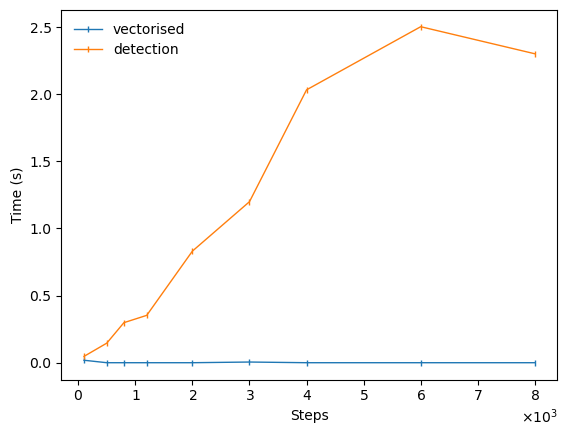

In [17]:
# Runtime comparison and plot

n = 500
pm = 0.6
pe = 0.2
pn = 0.2
pc = 0.9 #0.3
pi = 0. #0.6 

trialset = np.linspace(10,100000, 10000, dtype=int) # long runs
trialset = [10, 100, 200, 300, 400, 500, 600, 700, 800, 1000, 2000, 3000, 4000, 5000, 6000, 7000] # shorter run
detection_execution_times = []
vec_detection_execution_times = []

run = 1 # M set to 1 for testing
do_return = 1 # for return dataframe from various detection task function calls
shortrun = 1 
if shortrun:
    trialset = [100, 500, 800, 1200, 2000, 3000, 4000, 6000, 8000]

for n in trialset:
    df = pd.DataFrame()
    df['Md'], df['Ed'], df['Ad'], df['Vd'] = detection_trial(n, pm, pe, pn, pc, pi, run, do_return)
    df['Mv'], df['Ev'], df['Av'], df['Vv'] = vec_detection_trial(n, pm, pe, pn, pc, pi, run, do_return)
diff = np.subtract(detection_execution_times, vec_detection_execution_times)

rlim = len(vec_detection_execution_times)

plotpath = "C:\\Users\\swath\\SNN_fork\\plots\\"

"""
timeseriesplot(trialset, rlim, vec_detection_execution_times, 'vectorised', log=1)
timeseriesplot(trialset, rlim, detection_execution_times, 'detection', log=1)
plt.savefig(plotpath+'vecdetlog_times.png', dpi = 300)
plt.show()
"""

timeseriesplot(trialset, rlim, vec_detection_execution_times, 'vectorised', log=0)
timeseriesplot(trialset, rlim, detection_execution_times, 'detection', log=0)
#plt.savefig(plotpath+'vecdet_times.png', dpi = 300)

In [18]:
# Composition comparison (A,V)
n = 500
pm = 0.6
pe = 0.2
pn = 0.2
pc = 0.9 #0.3
pi = 0. #0.6 
run = 0
seed = 42
do_return = 1

df = pd.DataFrame()
df['M'], df['E'], df['A'], df['V'] = detection_trial(n, pm, pe, pn, pc, pi, run, do_return, seed = seed)
df['M_vec'], df['E_vec'], df['A_vec'], df['V_vec'] = vec_detection_trial(n, pm, pe, pn, pc, pi, run, do_return, seed = seed)

summary_df = pd.DataFrame() # will hold proportion of A and V in non- and vectorised functions (in %)
columns = ['A', 'A_vec', 'V', 'V_vec']
for col in columns:
    summary_df[col] = np.round(df[col].value_counts() / n * 100, 1)

summary_df # in % of n

,A,A_vec,V,V_vec
0,62.8,63.6,64.6,66.8
1,26.4,27.4,28.0,25.2
-1,10.8,9.0,7.4,8.0


# E transition in Detection Task

In [2]:
# Vectorised Detection trial
def vec_detection_trial_etransition(n, pm, pe, pn, pc, pi, repeats, run, do_return=True, random_seed=None):
    #start_time = time.time()  # Start the timer
    #random_seed = None
    if random_seed is not None:
        np.random.seed(random_seed)  # Set the random seed if provided

    df = pd.DataFrame()
    for trial in range(repeats):
        if run == 0:
            M = 1
        else:
            M = choice([-1, 0, 1], p=[pm/2, 1 -pm, pm/2]) # ground truth: M and E

            # Emit variable depends on M
            E = np.zeros(n, dtype=np.int32)
            if M:
                E[0] = choice([0, 1], p=[1-pe, pe])  # Initialize first element
                for i in range(1, n):
                    # Decide the next value based on the transition probabilities and previous value
                    E[i] = choice([0, 1], p=trans_prob[E[i-1]])
            # Distribution of A and V depends on M, E
            vals_no_e = np.array([-1, 0, 1]) # noise
            p_no_e = np.array([pn/2, 1-pn, pn/2])

            vals_e = np.array([-M, 0, M]) # incorrect, -, correct
            p_e = np.array([pi, 1-pc-pi, pc])

            A = np.where(E, choice(vals_e, size=n, p=p_e), choice(vals_no_e, size=n, p=p_no_e))
            V = np.where(E, choice(vals_e, size=n, p=p_e), choice(vals_no_e, size=n, p=p_no_e))
            #end_time = time.time()  # End the timer
            #vec_detection_execution_times.append(end_time - start_time)  # Append the execution time to the list
            for j in range(len(A)):
                    df = df.append({'Trial': trial, 'E': E[j], 'M': M, 'A': A[j], 'V': V[j]}, ignore_index=True)
    if do_return:
        return df    

## Proportion of A, V
def AV_proportiontest(df):
    # Create a pivot table summarizing the counts for 'A'
    summary_A = np.round((df.pivot_table(index='Trial', columns='A', aggfunc='size') / n * 100),1)
    summary_A.columns = ['A_' + str(int(col)) for col in summary_A.columns]

    # Create a pivot table summarizing the counts for 'V'
    summary_V = np.round((df.pivot_table(index='Trial', columns='V', aggfunc='size') / n * 100),1)
    summary_V.columns = ['V_' + str(int(col)) for col in summary_V.columns]

    # Create a pivot table summarizing the counts for 'E'
    summary_E = np.round((df.pivot_table(index='Trial', columns='E', aggfunc='size') / n * 100),1)
    summary_E.columns = ['E_' + str(int(col)) for col in summary_E.columns]

    
    # Merge the two summaries
    summary_df = pd.merge(summary_A, summary_V, left_index=True, right_index=True).merge(summary_E, left_index=True, right_index=True)
    
    return summary_df

In [3]:
# bookmark1
run=1
# Define the transition probability matrix for E
# trans_prob[e_current][e_next] is the 
# probability of transitioning from e_current to e_next
trans_prob = {
    0: [0.8, 0.2],  # Probabilities for transitioning from E=0
    1: [0.7, 0.3],  # Probabilities for transitioning from E=1
}

n = 100
pm = 0.5 # smaller doesnt mean sparser signals from prey !!!!!!!!
pe = 0.2 # for first value of E
pn = 0.1 # smaller = less noisy (more zeros)
pc = 0.7 #0.3
pi = 0.2 #0.6 
repeats = 10

df_etrans_local = vec_detection_trial_etransition(n, pm, pe, pn, pc, pi, repeats, run, random_seed=42)
df_etrans = DetectionTask_Etrans_test(pm, pe, pn, pc, pi, n, repeats, trans_prob, run, random_seed=42)


In [16]:
etrans_trials = df_etrans.generate_trials
etrans_trials = df_etrans.generate_trials
etrans_trials.M

array([ 1, -1,  1, -1,  0, -1,  0,  1,  0,  0])

In [13]:
trials = df_etrans.generate_trials
trials.A[0]
trials.M

AttributeError: 'DetectionTask_Etrans_test' object has no attribute 'M'

In [5]:

# Test proportion of A and V 
summary_df = pd.DataFrame()
for trial in range(repeats):
    df = df_etrans[df_etrans['Trial'] == trial]
    summary_df = summary_df.append(AV_proportiontest(df))
for rr in range(repeats):
    summary_df.loc[rr, 'M'] = df_etrans[df_etrans['Trial'] == rr]['M'].values[0]
summary_df['M'] = summary_df['M'].astype(int)
# Reordering columns
reordered_columns = ['M', 'E_0',  'A_0', 'V_0', 'A_1', 'V_1', 'A_-1', 'V_-1']
reordered_summary_df = summary_df[reordered_columns]
reordered_summary_df

TypeError: 'DetectionTask_Etrans_test' object is not subscriptable

In [8]:
def plot_trial_data(A, V, M, E=0, llim=0, rlim=100):
    Mlabel = {0: '-', 1: '>', -1: '<'}

    time = np.arange(0, rlim - llim, 1)
    plt.figure(figsize=(15, 1))

    plt.scatter(time[A == -1], np.zeros_like(time[A == -1]), marker='<', s=50, c='purple')
    plt.scatter(time[A == 0], np.zeros_like(time[A == 0]), marker=' ', s=50)
    plt.scatter(time[A == 1], np.zeros_like(time[A == 1]), marker='>', s=50, c='red')

    plt.scatter(time[V == -1], np.ones_like(time[V == -1]) * 0.3, marker='<', s=50, c='purple')
    plt.scatter(time[V == 0], np.ones_like(time[V == 0]) * 0.3, marker=' ', s=50)
    plt.scatter(time[V == 1], np.ones_like(time[V == 1]) * 0.3, marker='>', s=50, c='red')

    if np.mean(E) != 0: # vertical lines if E is provided
        E = E.reset_index(drop=True)
        locations = np.where(E == 1)[0]
        for location in locations:
            if location == locations[-1]:
                plt.axvline(time[location], 0, 1, color='orchid', linestyle='solid', alpha=0.25, label="E = 1")
            else:
                plt.axvline(time[location], 0, 1, color='orchid', linestyle='solid', alpha=0.25)

    plt.legend(frameon=False)
    plt.title(f"M: {M}")
    plt.xticks(time)
    plt.ylim(top=1., bottom=-1.)
    plt.yticks([])
    plt.xticks(np.arange(time[0], time[-1], 5))

    # Remove the box enclosing the plot
    ax = plt.gca()  # Get the current axes instance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xlabel('Steps')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


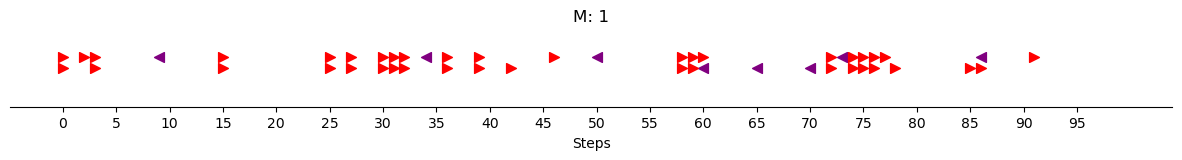

In [22]:
trial = 8
A = etrans_trials.A[trial-1]
V = etrans_trials.V[trial-1]
M = etrans_trials.M[trial-1]
#E = etrans_trials.E[trial-1]

plot_trial_data(A, V, M)

In [11]:
llim, rlim, trial = 0, 100, 5
A = df_etrans[df_etrans['Trial'] == trial]['A'][llim:rlim]
V = df_etrans[df_etrans['Trial'] == trial]['V'][llim:rlim]
M = str(df_etrans[df_etrans['Trial'] == trial]['M'].tolist()[0])
E = df_etrans[df_etrans['Trial'] == trial]['E'][llim:rlim]

plot_trial_data(A, V, M, E)

TypeError: 'DetectionTask_Etrans_test' object is not subscriptable

In [ ]:
# Visualise trials uing a random trial
trial = np.random.randint(repeats)
print('Trial', trial)
plt.figure(figsize=(10,5))
plt.plot(np.arange(0, n, 1), df_etrans[df_etrans['Trial'] == trial]['A'], marker = '|', ls = '', ms = 8, label = 'A');
plt.plot(np.arange(0, n, 1), df_etrans[df_etrans['Trial'] == trial]['V'], marker = '.', ls = '', ms = 3, label = 'V');
plt.title(f"M: {str(df_etrans[df_etrans['Trial'] == trial]['M'].tolist()[0])}")
plt.yticks([-1, 0, 1])
plt.xlabel('Steps')
plt.legend(frameon=0, bbox_to_anchor=(1,1))

# Refactoring

@dataclass
class DetectionTask_Etrans(Task):
    pm: float
    pe: float
    pn: float
    pc: float
    pi: float
    n:  int
    repeats: int

    df = pd.DataFrame()
    for trial in range(repeats):
        if run == 0:
            M = 1
        else:
            M = choice([-1, 0, 1], p=[pm/2, 1 -pm, pm/2]) # ground truth: M and E

            # Emit variable depends on M
            E = np.zeros(n, dtype=np.int32)
            if M:
                E[0] = choice([0, 1], p=[1-pe, pe])  # Initialize first element
                for i in range(1, n):
                    # Decide the next value based on the transition probabilities and previous value
                    E[i] = choice([0, 1], p=trans_prob[E[i-1]])
            # Distribution of A and V depends on M, E
            vals_no_e = np.array([-1, 0, 1]) # noise
            p_no_e = np.array([pn/2, 1-pn, pn/2])

            vals_e = np.array([-M, 0, M]) # incorrect, -, correct
            p_e = np.array([pi, 1-pc-pi, pc])

            A = np.where(E, choice(vals_e, size=n, p=p_e), choice(vals_no_e, size=n, p=p_no_e))
            V = np.where(E, choice(vals_e, size=n, p=p_e), choice(vals_no_e, size=n, p=p_no_e))
            #end_time = time.time()  # End the timer
            #vec_detection_execution_times.append(end_time - start_time)  # Append the execution time to the list
            for j in range(len(A)):
                    df = df.append({'Trial': trial, 'E': E[j], 'M': M, 'A': A[j], 'V': V[j]}, ignore_index=True)
#return df    
 

In [10]:
# Vectorised Detection trial
def vec_detection_trial_etransition(n, pm, pe, pn, pc, pi, repeats, run, do_return=True, random_seed=None):
    #start_time = time.time()  # Start the timer
    #random_seed = None
    if random_seed is not None:
        np.random.seed(random_seed)  # Set the random seed if provided

    df = pd.DataFrame()
    for trial in range(repeats):
        if run == 0:
            M = 1
        else:
            M = choice([-1, 0, 1], p=[pm/2, 1 -pm, pm/2]) # ground truth: M and E

            # Emit variable depends on M
            E = np.zeros(n, dtype=np.int32)
            if M:
                E[0] = choice([0, 1], p=[1-pe, pe])  # Initialize first element
                for i in range(1, n):
                    # Decide the next value based on the transition probabilities and previous value
                    E[i] = choice([0, 1], p=trans_prob[E[i-1]])
            # Distribution of A and V depends on M, E
            vals_no_e = np.array([-1, 0, 1]) # noise
            p_no_e = np.array([pn/2, 1-pn, pn/2])

            vals_e = np.array([-M, 0, M]) # incorrect, -, correct
            p_e = np.array([pi, 1-pc-pi, pc])

            A = np.where(E, choice(vals_e, size=n, p=p_e), choice(vals_no_e, size=n, p=p_no_e))
            V = np.where(E, choice(vals_e, size=n, p=p_e), choice(vals_no_e, size=n, p=p_no_e))
            #end_time = time.time()  # End the timer
            #vec_detection_execution_times.append(end_time - start_time)  # Append the execution time to the list
            for j in range(len(A)):
                    df = df.append({'Trial': trial, 'E': E[j], 'M': M, 'A': A[j], 'V': V[j]}, ignore_index=True)
    if do_return:
        return df 

In [12]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
from numpy.random import choice, seed
from multisensory import Task
from multisensory import DetectionTask
from multisensory import DetectionTask_Etrans_test
import random

# NOTE: pe doesnt mean the same in the time dependent scenario

# bookmar 2
run=1
# Define the transition probability matrix for E
# trans_prob[e_current][e_next] is the 
# probability of transitioning from e_current to e_next
trans_prob = {
    0: [0.8, 0.2],  # Probabilities for transitioning from E=0
    1: [0.7, 0.3],  # Probabilities for transitioning from E=1
}

n = 100
pm = 0.5 # smaller doesnt mean sparser signals from prey !!!!!!!!
pe = 0.2 # for first value of E
pn = 0.1 # smaller = less noisy (more zeros)
pc = 0.7 #0.3
pi = 0.2 #0.6 
nb_trials = 10
run = 1 # 0 for testing

p = {
    "n": n,
    "pm": pm,
    "pe": pe,
    "pn": pn,
    "pc": pc,
    "pi": pi,
    "repeats": nb_trials,
    "trans_prob": trans_prob,
    "run": run,
    "random_seed": 42,
    
}


# Generate trials
task = DetectionTask_Etrans_test(**p)
trials = task.generate_trials()

In [14]:
type(task)

multisensory.DetectionTask_Etrans_test

In [13]:
trials.M

array([-1,  0,  0, -1,  1,  0,  1,  0,  1,  0])

In [8]:
idx = np.random.randint(nb_trials)
plot_trial_data(trials2.A[idx], trials2.V[idx], trials2.M[idx])

NameError: name 'plot_trial_data' is not defined

In [27]:
# Test proportion of A and V 
summary_df2 = pd.DataFrame()
for trial in range(repeats):
    df2 = trials[trials['Trial'] == trial]
    summary_df2 = summary_df2.append(AV_proportiontest(df2))

for rr in range(repeats):
    summary_df2.loc[rr, 'M'] = trials[trials['Trial'] == rr]['M'].values[0]


summary_df2['M'] = summary_df2['M'].astype(int)
# Reordering columns
reordered_columns = ['M', 'E_0',  'A_0', 'V_0', 'A_1', 'V_1', 'A_-1', 'V_-1']
reordered_summary_df2 = summary_df2[reordered_columns]
reordered_summary_df2

,M,E_0,A_0,V_0,A_1,V_1,A_-1,V_-1
Trial,,,,,,,,
0,0,100.0,93.0,94.0,5.0,5.0,2.0,1.0
1,-1,80.0,69.0,78.0,12.0,3.0,19.0,19.0
2,-1,81.0,74.0,77.0,11.0,9.0,15.0,14.0
3,-1,75.0,70.0,70.0,8.0,9.0,22.0,21.0
4,0,100.0,93.0,89.0,4.0,5.0,3.0,6.0
5,-1,76.0,64.0,65.0,10.0,11.0,26.0,24.0
6,0,100.0,87.0,89.0,8.0,4.0,5.0,7.0
7,-1,76.0,64.0,65.0,10.0,12.0,26.0,23.0
8,0,100.0,88.0,88.0,7.0,9.0,5.0,3.0


### Objective function: pseudocode

In [ ]:
# Pseudocode for objective function for optimisation
def evaluate_parameters(pm, pe, pn, pc, pi): # Parameters to optimise
    # Function to generate A, V
    df = genfunc()
    
    # Run FtA algorithm
    metric_FtA = FtA(df)  
    # Run AtF algorithm
    metric_AtF = AtF(df) 
    
    # Calculate the difference metric you're interested in
    difference_metric = diff_met(metric_FtA, metric_AtF)  
    
    return difference_metric
